In [4]:
########### loading packages
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from gensim import corpora, models, similarities 
import spacy
import itertools
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore")

In [5]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [6]:
#df = pd.read_csv('../MA_thesis/FDIC_df_addyear_cl.csv')

In [7]:
df3  = pd.read_csv('../../Downloads/FDIC_df_addyear-csv-3.csv')

In [8]:
text_ls2 = list(df3['Text'])
len(text_ls2)

9982

In [9]:
totaltextls2 = [line for line in text_ls2 if line != ' 'and str(line) != 'nan']

In [10]:
text_ls2[9240]

nan

In [11]:
rm_ls = []
for i, line in enumerate(text_ls2):
    if not (line != ' 'and str(line) != 'nan'):
        rm_ls.append(i)

In [13]:
non_df = df3.index.isin(rm_ls)
df3_9618 = df3[~non_df]

In [18]:
df3_96181 = df3_9618.sort_values('year')

In [22]:
time_slice = []
for i in df3_96181.groupby('year')['month'].count():
    time_slice.append(i-1)

In [24]:
#time_slice

In [25]:
text_ls3 = list(df3_9618['Text'])
len(text_ls3)

9618

In [26]:
totaltextls3 = [line for line in text_ls3 if line != ' 'and str(line) != 'nan']
len(totaltextls3)

9618

In [27]:
# load stop words
en_stop = get_stop_words('en')
en_stop_orig2 = en_stop
en_stop2 = en_stop + ['fdic','shall','decision','order','date','enforc',"'s",
                      'fdi','deposit','feder','hereby','thereafter',
                      'i','ii','iii','however','then','therefore',
                      'within','decisions','orders','and/or',
                     'associate', 'director','further','andor'
                      'respondent','repondents','whereby','thereof']
#,
#                    'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v',
#                    'x','y','z','sh','ph','gh','th','nt']

In [28]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['fdic','shall','decision','order','date','bank','enforc',"'s",'bank','days','report',
                    'banking','alj','u.s.c','fdi','deposit',
                   'thereafter','i','ii','iii','however','then','therefore','within','decisions','orders','and/or','~o','o~']

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [29]:
# regex pattern
combined_pat = r'|'.join(('\((.*?)\)', '\[(.*?)\]', "\'",'\"','x97',"\\'",'\\"'))

In [30]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [31]:
def tokenized_gensim(total_text):
    tokenized_text = []
    for k, text_raw in enumerate(total_text):
        text = re.sub(combined_pat, ' ', text_raw, flags= re.IGNORECASE) 
        if k < 4322 :
            flag = 'html'
            try:
                tokens = [word for sent in nltk.sent_tokenize(text)[2:-1] \
                  for word in nltk.word_tokenize(sent) if word not in en_stop2]              
                #tt  = list(itertools.chain(*tokens))
                filtered_tokens = []
                for token in tokens:
                    if re.search('[a-zA-Z]', token):
                        token = re.sub(r'[^\w\s]', '', token)
                        filtered_tokens.append(token.lower())
                stems = [stemmer.stem(t) for t in filtered_tokens if t not in en_stop2]
                stems = [word for word in stems if word not in en_stop2]
                tokenized_text.append(stems)
            except Exception as e:
                print(e)
                print(k)
        else:
            flag = 'pdf'
            try:
                tokens = [word for sent in nltk.sent_tokenize(text)[:-1] \
                  for word in nltk.word_tokenize(sent) if word not in en_stop2]
                #tt  = list(itertools.chain(*tokens))
                filtered_tokens = []
                for token in tokens:
                    if re.search('[a-zA-Z]', token):
                        token = re.sub(r'[^\w\s]', '', token)
                        filtered_tokens.append(token.lower())
                stems = [stemmer.stem(t) for t in filtered_tokens if t not in en_stop2]
                stems = [word for word in stems if word not in en_stop2]
                tokenized_text.append(stems)  
            except Exception as e1:
                print(e1)
                print(k)
    return tokenized_text

In [16]:
#nltk.sent_tokenize(totaltextls2[431])

In [32]:
%time data_words3 = tokenized_gensim(totaltextls3)

CPU times: user 9min 12s, sys: 7.72 s, total: 9min 20s
Wall time: 10min 5s


In [33]:
# Build the bigram and trigram models
%time bigram3 = gensim.models.Phrases(data_words3, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod3 = gensim.models.phrases.Phraser(bigram3)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 24.5 s, sys: 1.41 s, total: 25.9 s
Wall time: 28.6 s
CPU times: user 16.7 s, sys: 237 ms, total: 16.9 s
Wall time: 20.1 s


In [41]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in en_stop2] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod3[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod2[bigram_mod2[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #print(sent)
        doc = nlp(" ".join(sent))
        #print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
# Remove Stop Words
%time data_words_nostops3 = remove_stopwords(data_words3)
# Form Bigrams
%time data_words_bigrams3 = make_bigrams(data_words_nostops3)

CPU times: user 50.4 s, sys: 3.68 s, total: 54.1 s
Wall time: 1min 2s
CPU times: user 36.9 s, sys: 1.83 s, total: 38.7 s
Wall time: 43.4 s


In [43]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized3 = lemmatization(data_words_bigrams3, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized)

CPU times: user 11min 21s, sys: 1min 18s, total: 12min 39s
Wall time: 12min 5s


In [44]:
#create a Gensim dictionary from the texts
%time d_gen_rev3 = corpora.Dictionary(data_lemmatized3)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time d_gen_rev3.filter_extremes(no_below=10, no_above=0.5)

CPU times: user 5.8 s, sys: 768 ms, total: 6.57 s
Wall time: 6.81 s
CPU times: user 189 ms, sys: 18 ms, total: 207 ms
Wall time: 218 ms


In [428]:
d_gen_rev2.num_pos

5756437

In [429]:
import operator
#x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(d_gen_rev2.token2id.items(), key=operator.itemgetter(1), reverse = True)
print(type(d_gen_rev2.token2id))
#sorted_x

<class 'dict'>


In [45]:
#convert the dictionary to a bag of words corpus for reference
%time c_gen_rev3 = [d_gen_rev3.doc2bow(text) for text in data_lemmatized3]

CPU times: user 4.06 s, sys: 815 ms, total: 4.88 s
Wall time: 5.15 s


In [46]:
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy
from gensim.matutils import hellinger

In [47]:
#time_slice = []

In [24]:
####### LDA model
%time lda_w10 = models.LdaModel(c_gen_rev2, num_topics=10, \
                                   id2word=d_gen_rev2, update_every=5, chunksize=10000,  passes=20)

CPU times: user 8min 57s, sys: 35.6 s, total: 9min 33s
Wall time: 9min 37s


In [432]:
#dictionary = corpora.Dictionary(do)
#corpus = [dictionary.doc2bow(sent) for sent in documents]
vocab = list(d_gen_rev2.values()) #list of terms in the dictionary
#vocab_tf = [dict(i) for i in corpus]
#vocab_tf = list(pd.DataFrame(vocab_tf).sum(axis=0))
#vocab = list(d_gen_rev.values())
len(vocab)

4753

In [433]:
d_gen_rev2.num_pos

5756437

In [434]:
d_gen_rev2.num_nnz

1705481

In [435]:
d_gen_rev2.num_docs

9618

In [436]:
%time vocab_tf2 = [dict(i) for i in c_gen_rev2]

CPU times: user 240 ms, sys: 617 ms, total: 857 ms
Wall time: 2.2 s


In [437]:
len(vocab_tf2)

9618

In [438]:
%time vocab_tf2 = list(pd.DataFrame(vocab_tf2).sum(axis=0)) #list of term frequencies

CPU times: user 15 s, sys: 3.73 s, total: 18.7 s
Wall time: 23.6 s


In [372]:
lda_w10.log_perplexity(c_gen_rev2, total_docs=len(c_gen_rev2))

-5.910462173590097

In [439]:
a = pd.DataFrame()
a['vocab'] = vocab
a['count'] = vocab_tf2

In [440]:
a1 = a.sort_values(by=['count'], ascending=False)

In [441]:
# Get the topic related words 
topics_matrix102 = lda_w10.show_topics(formatted=False, num_words=10, num_topics=35)
topics_matrix102 = np.array(topics_matrix102, dtype=object)
topic_words102 = topics_matrix102[:,1]

In [442]:
allls = []
for k in range(len(topic_words102)):
    wordls = []
    for i, v in topic_words102[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)

['loan', 'report', 'oper', 'region', 'polici', 'board', 'asset', 'manag', 'secur', 'examin']
['plan', 'board', 'loan', 'write', 'region', 'review', 'capit', 'report', 'asset', 'manag']
['penalti', 'civil', 'money', 'pay', 'assess', 'respond', 'flood', 'agre', 'amount', 'desist']
['applic', 'depositori', 'direct', 'file', 'particip', 'affair', 'approv', 'conduct', 'action', 'capit']
['plan', 'board', 'report', 'loan', 'review', 'asset', 'capit', 'write', 'manag', 'credit']
['respond', 'compani', 'time', 'hold', 'board', 'offic', 'agreement', 'liabil', 'control', 'trust']
['capit', 'loan', 'asset', 'examin', 'percent', 'total', 'classifi', 'unsaf', 'unsound', 'loss']
['particip', 'prohibit', 'respond', 'breach', 'duti', 'vote', 'fiduciari', 'unsaf', 'unsound', 'conduct']
['complianc', 'report', 'board', 'procedur', 'program', 'review', 'includ', 'ensur', 'provid', 'audit']
['respond', 'loan', 'board', 'credit', 'make', 'find', 'alj', 'interest', 'time', 'offic']


In [443]:
dat_gen_rev2 = pyLDAvis.gensim.prepare(lda_w10, c_gen_rev2, d_gen_rev2)
pyLDAvis.display(dat_gen_rev2)

In [194]:
from collections import defaultdict
def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}
    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms

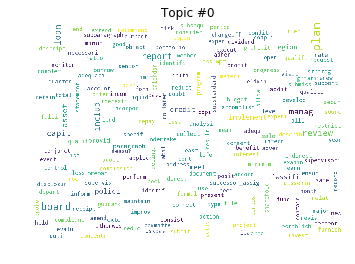

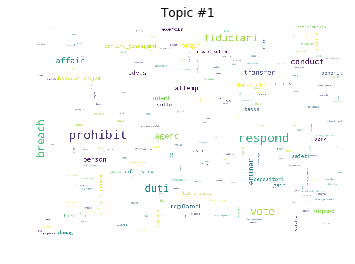

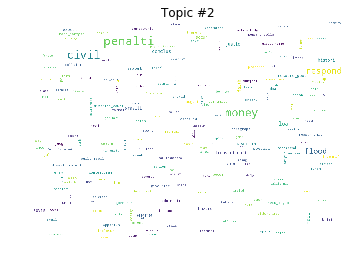

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


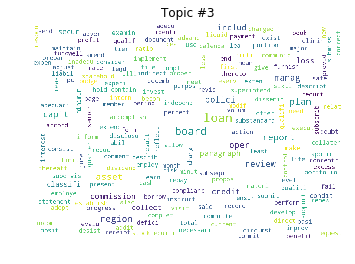

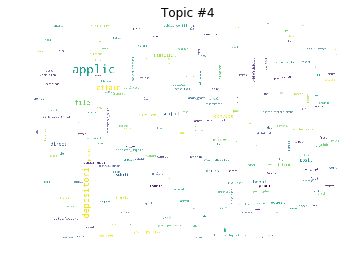

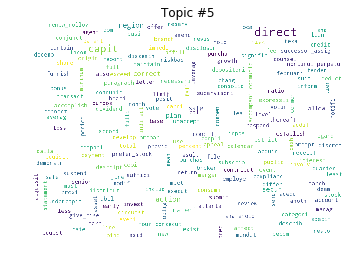

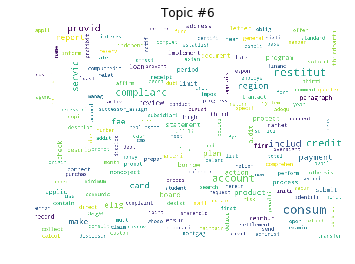

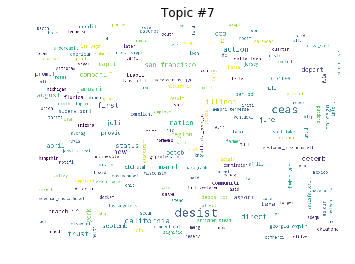

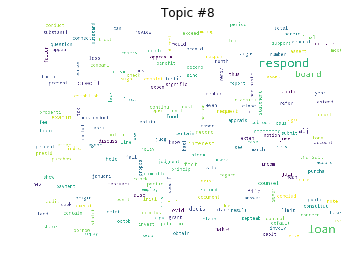

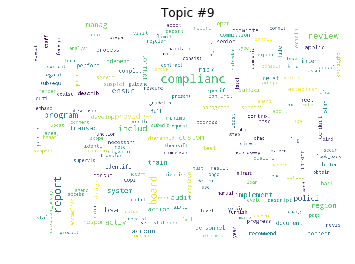

In [232]:
# Wordclouds
wc = WordCloud(
    background_color="white",
    max_words=200,
    width=1024,
    height=720,
    stopwords=en_stop_orig2#stopwords.words('english')
)
#WordCloud().fit_words(dict(lda.show_topic(t, 200)))
for t in range(lda_w10.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(lda_w10.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [202]:
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import numpy as np
import _pickle as cPickle
#import cPickle as pickle
import sompy
import os,sys,re
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import words
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phraser, Phrases
from sklearn.feature_extraction.text import CountVectorizer

In [222]:
mapsize = [30,30]
som = sompy.SOMFactory.build(
    topic_matrix,
    mapsize,
    mask=None,
    mapshape='planar',
    lattice='rect',
    normalization='var',
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    name='sompy')
som.train(n_job=8, verbose='info')

 Training...
 pca_linear_initialization took: 0.210000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 3

 epoch: 1 ---> elapsed time:  0.315000, quantization error: 2.251594

 epoch: 2 ---> elapsed time:  0.289000, quantization error: 1.299289

 epoch: 3 ---> elapsed time:  0.268000, quantization error: 0.674996

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 4

/Users/misun/anaconda/lib/python3.5/site-packages/sompy/sompy.py:350: RuntimeWarning: invalid value encountered in sqrt
  np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
 epoch: 1 ---> elapsed time:  0.250000, quantization error: nan

nan quantization error, exit train

 epoch: 2 ---> elapsed time:  0.259000, quantization error: nan

nan quantization error, exit train

 epoch: 3 ---> elapsed time:  0.253000, quantization error: nan

nan quantization error, e

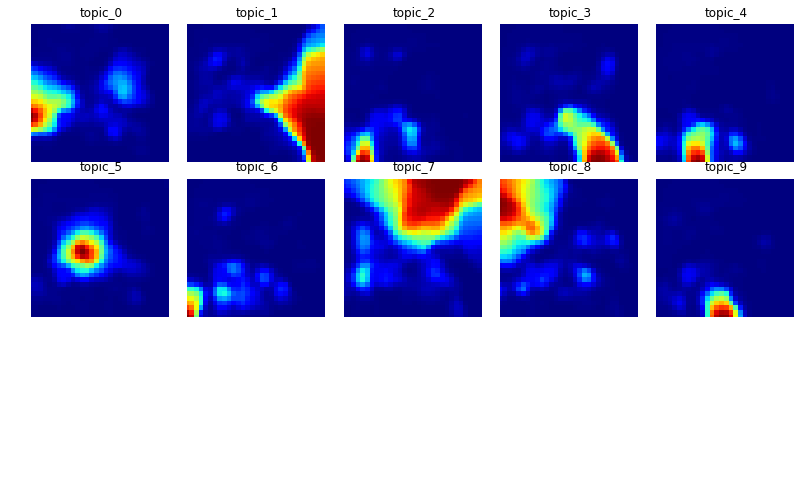

In [223]:
som.component_names = ["_".join([t,str(i)]) for i,t in enumerate(['topic']*10)]
v = sompy.mapview.View2DPacked(30, 30, '',text_size=10)
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=5)

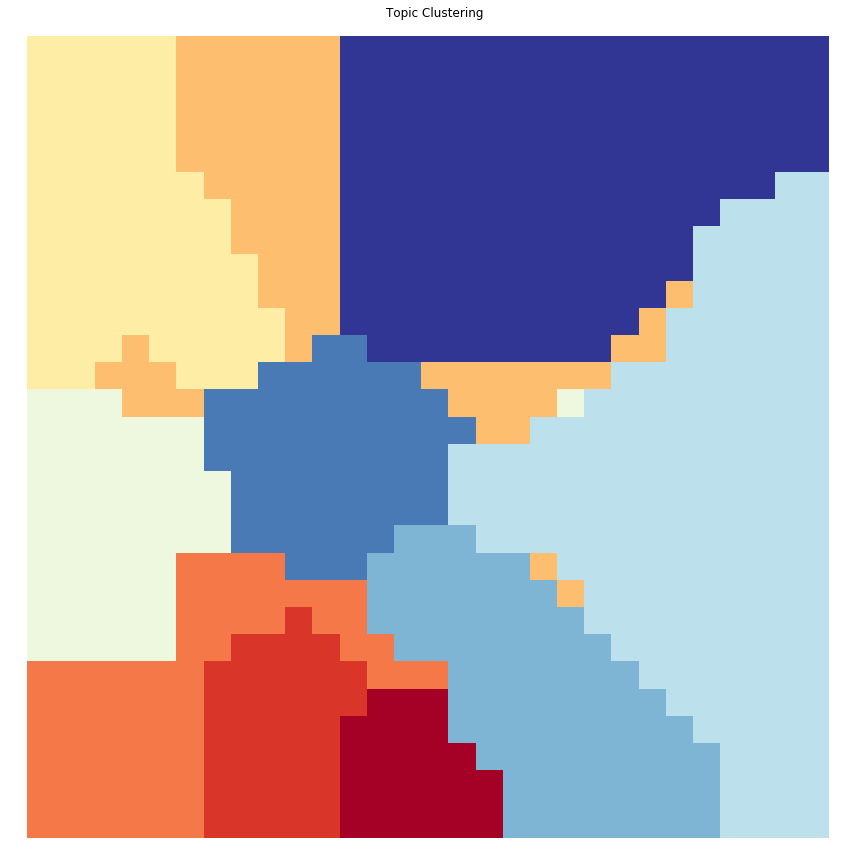

In [225]:
v1 = sompy.mapview.View2DPacked(10, 10, 'Topic Clustering',text_size=10)
cl = som.cluster(n_clusters=10)
# I am using the default plotting methods. I am sure this can be made prettier...
v1.show(som, what='cluster')

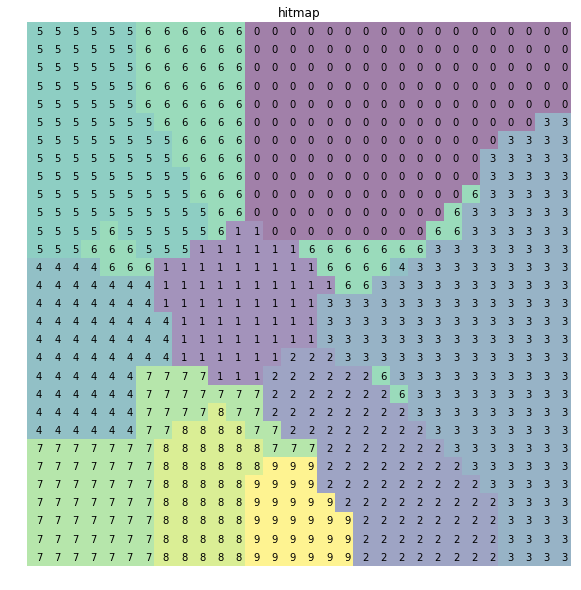

array([[  0,   0,   0],
       [  0,   1,   1],
       [  0,   2,   2],
       ...,
       [ 29,  27, 897],
       [ 29,  28, 898],
       [ 29,  29, 899]])

In [226]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

In [240]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, 5))
    parameter_list[0] = start
    grid ={}
    for num_topics in parameter_list:
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        models.LdaModel(c_gen_rev, num_topics=25, \
                                   id2word=d_gen_rev, update_every=5, chunksize=10000,  passes=20)
        model = models.LdaModel(corpus, num_topics=num_topics,\
                                id2word=dictionary, update_every=5, chunksize=10000,  passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        grid[num_topics]=[]
        perplex=model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics].append(perplex)

    return model_list, coherence_values, grid

In [27]:
limit=15; start=2; step=1;
parameter_list2 = list(range(2, limit, 1))
parameter_list2[0] = start

In [31]:
coherence_values2 = []
model_list2 = []
parameter_list2 = list(range(2, limit, 1))
parameter_list2[0] = start
grid2 ={}
for num_topics in parameter_list2:
    print(num_topics)
    #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    model2 = models.LdaModel(c_gen_rev2, num_topics=num_topics,\
                            id2word=d_gen_rev2, update_every=5, chunksize=10000,  passes=20)
    model_list2.append(model2)    
    grid2[num_topics]=[]
    perplex2=model2.log_perplexity(c_gen_rev2, total_docs=len(c_gen_rev2))
    grid2[num_topics].append(perplex2)
    coherencemodel2 = CoherenceModel(model=model2, texts=data_lemmatized2, dictionary=d_gen_rev2, coherence='c_v')
    coherence_values2.append(coherencemodel2.get_coherence())

2
3
4
5
6
7
8
9
10
11
12
13
14


In [94]:
coherencemodel2 = CoherenceModel(model=lda2, texts=data_lemmatized2, dictionary=d_gen_rev2, coherence='c_v')
coherencemodel2.get_coherence()

0.47156010224983635

In [242]:
# Can take a long time to run.
%time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=d_gen_rev, corpus=c_gen_rev,\
                                                        texts=gensim_rev, start=2, limit=100, step=5)

/Users/misun/anaconda/lib/python3.5/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 56min, sys: 10.2 s, total: 56min 10s
Wall time: 57min 20s


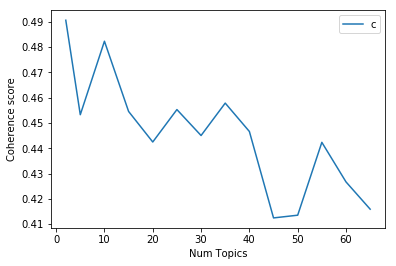

In [381]:
# Show CV
#x = range(start, limit, step)
plt.plot(parameter_list2, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [382]:
#print(coherence_values)
#parameter_list
cv={}
for i,v in enumerate(parameter_list2):
    cv[v] =coherence_values2[i] 
cv    

{2: 0.49056568957066304,
 5: 0.45323531297268876,
 10: 0.4822721195297799,
 15: 0.4545253645844654,
 20: 0.44245359189229994,
 25: 0.4552645760188628,
 30: 0.4450120671605045,
 35: 0.45781724452335926,
 40: 0.446610004731523,
 45: 0.41244830801210713,
 50: 0.41352363876044107,
 55: 0.4423152210732204,
 60: 0.4266775613320408,
 65: 0.4159027158682296}

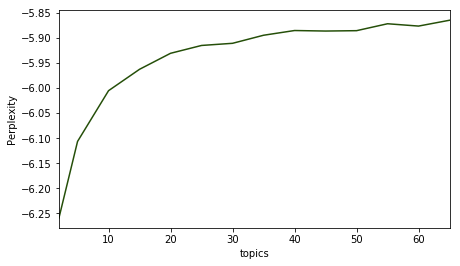

In [383]:
# perplexity
df2 = pd.DataFrame(grid2)
ax = plt.figure(figsize=(7, 4)).add_subplot(111)
df2.iloc[0].transpose().plot(ax=ax,  color="#254F09")
plt.xlim(parameter_list2[0], parameter_list2[-1])
plt.ylabel('Perplexity')                                              
plt.xlabel('topics')
plt.show()     

In [384]:
grid2

{2: [-6.2590870888668535],
 5: [-6.106497864071086],
 10: [-6.005226807839119],
 15: [-5.962533398530878],
 20: [-5.9306300999916735],
 25: [-5.914992408736519],
 30: [-5.910702401281825],
 35: [-5.894625068487319],
 40: [-5.885202282928633],
 45: [-5.886236159252294],
 50: [-5.885500803942089],
 55: [-5.871689196129777],
 60: [-5.8763273379442085],
 65: [-5.864689303531147]}

In [253]:
for i, v in grid_rev.items():
    #print(i,v)
    print(i, np.exp2(-v[0]))

65 20.440896352382442
2 34.26868749341612
35 21.012467728469694
5 28.09472757028017
70 20.660888690444537
40 20.64791421007212
10 24.30401549118283
75 20.443830014409787
45 20.56153925303819
15 22.717248897583005
80 20.778979253136868
50 20.538661284267004
20 21.935665477297974
85 20.80983296049498
55 20.720664629398396
25 21.725970969956496
90 20.82901389927635
60 20.680650168807425
30 20.99440444472439
95 20.6693608275149


In [261]:
# import pickle
# with open("test.txt", "wb") as fp:   #Pickling
#     pickle.dump(tokenized_text, fp)

In [196]:
dictionary.save('dictionary_whole10.dict')

In [227]:
dictionary = dictionary.load('dictionary_whole10.dict')

In [197]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in tokenized_text]

CPU times: user 5.03 s, sys: 300 ms, total: 5.33 s
Wall time: 7.69 s


In [198]:
corpora.MmCorpus.serialize('corpus_whole10.mm', corpus)

In [228]:
%time lda = models.LdaModel(corpus, num_topics=25, id2word=dictionary, update_every=5, chunksize=10000,  passes=20)

CPU times: user 8min 51s, sys: 35.5 s, total: 9min 27s
Wall time: 9min 4s


In [134]:
#import logging
#logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [203]:
ldamallet = lda
optimal_model = lda

In [139]:
#lda.save('topic_whole10.model')

In [204]:
# Show Topics
#print(ldamallet.show_topics(formatted=False))

In [205]:
# Compute Coherence Score
#coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

In [145]:
#lda_w10.diff

In [141]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_w10, corpus=c_gen_rev2, texts=data_lemmatized2):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_w10, corpus=c_gen_rev2, texts=data_lemmatized2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [157]:
df_dominant_topic['year'] = df3['year']

In [160]:
# Show
df_dominant_topic.groupby('Dominant_Topic').count()

,Document_No,Topic_Perc_Contrib,Keywords,Text,year
Dominant_Topic,,,,,
0.0,994,994,994,994,994
1.0,1636,1636,1636,1636,1636
2.0,1939,1939,1939,1939,1939
3.0,820,820,820,820,820
4.0,503,503,503,503,503
5.0,181,181,181,181,181
6.0,93,93,93,93,93
7.0,2656,2656,2656,2656,2656
8.0,448,448,448,448,448


In [ ]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet#.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [257]:
#df_topic_sents_keywords

In [249]:
# Show
#sent_topics_sorteddf_mallet['Text'].iloc[0]

In [167]:
#totaltextls2[6584]

In [169]:
# Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

In [259]:
#topic_counts

In [260]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

7.0    0.2761
2.0    0.2016
1.0    0.1701
0.0    0.1033
3.0    0.0853
4.0    0.0523
8.0    0.0466
9.0    0.0362
5.0    0.0188
6.0    0.0097
Name: Dominant_Topic, dtype: float64

In [168]:
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,7.0,"desist, ceas, new, illinoi, california, first,...",994.0,0.1033
1,7.0,"desist, ceas, new, illinoi, california, first,...",1636.0,0.1701
2,7.0,"desist, ceas, new, illinoi, california, first,...",1939.0,0.2016
3,7.0,"desist, ceas, new, illinoi, california, first,...",820.0,0.0853
4,3.0,"loan, board, plan, asset, region, report, oper...",503.0,0.0523
5,8.0,"respond, loan, board, credit, make, interest, ...",181.0,0.0188
6,2.0,"penalti, civil, money, respond, flood, agre, l...",93.0,0.0097
7,7.0,"desist, ceas, new, illinoi, california, first,...",2656.0,0.2761
8,1.0,"respond, prohibit, breach, duti, fiduciari, vo...",448.0,0.0466
9,7.0,"desist, ceas, new, illinoi, california, first,...",348.0,0.0362


In [217]:
# Get the topic related words 
topics_matrix = lda.show_topics(formatted=False, num_words=15, num_topics=35)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

In [218]:
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)

['capit', 'asset', 'examin', 'percent', 'total', 'unsaf', 'unsound', 'condit', 'classifi', 'loan', 'ratio', 'oper', 'respond', 'advers', 'board']
['camp', 'applic', 'plan', 'theapprov', 'director', 'depositori', 'board', 'review', 'capit', 'loan', 'polici', 'written', 'approv', 'region', 'orindirect']
['florida', 'ofr', 'beach', 'miami', 'atlanta', 'tallahasse', 'statut', 'delawar', 'chapter', 'wilmington', 'georgia', 'palm', 'tampa', 'offic', 'great']
['michigan', 'ofir', 'montana', 'nebraska', 'ann', 'comp', 'jame', 'offic', 'mich', 'gordon', 'john', 'w', 'wester', 'code', 'richard']
['director', 'plan', 'board', 'loan', 'region', 'commission', 'review', 'capit', 'includ', 'asset', 'written', 'polici', 'manag', 'credit', 'meet']
['plan', 'board', 'supervisori', 'asset', 'review', 'capit', 'loan', 'includ', 'manag', 'credit', 'polici', 'written', 'classifi', 'implement', 'approv']
['ox', 'respond', 'ofth', 'unsaf', 'duti', 'corporationwashington', 'financialinstitut', 'aninstitutionaf

In [214]:
# Draw the log-perplexity to get the optimal number of topics
parameter_list = list(range(0, 100, 5))
parameter_list[0] = 1

grid ={}
for parameter_value in parameter_list:
    %time model = models.LdaModel(corpus, num_topics=parameter_value,\
                            id2word=dictionary, update_every=5, chunksize=10000,  passes=20)
    grid[parameter_value]=[]

    perplex=model.log_perplexity(corpus, total_docs=len(corpus))
    grid[parameter_value].append(perplex)

In [229]:
#grid

{1: [-6.842375426572742],
 5: [-6.473092162424055],
 10: [-6.3412580625586115],
 15: [-6.297645093159058],
 20: [-6.261787592058588],
 25: [-6.249782820047985],
 30: [-6.241533633189906],
 35: [-6.2181008490451575],
 40: [-6.21400434513449],
 45: [-6.211523884929179],
 50: [-6.204256558137079],
 55: [-6.193323847281065],
 60: [-6.195882828718008],
 65: [-6.196838882842539],
 70: [-6.196981443949561],
 75: [-6.182586596443315],
 80: [-6.182853434729188],
 85: [-6.196208560079937],
 90: [-6.183806948661727],
 95: [-6.186880880832522],
 100: [-6.178843020585641],
 105: [-6.170650081079592],
 110: [-6.16797043721525],
 115: [-6.175144407387024],
 120: [-6.171752103899074],
 125: [-6.170764098800578]}

In [ ]:
df = pd.DataFrame(grid)
ax = plt.figure(figsize=(7, 4, dpi = 100)).add_subplot(111)
df.iloc[0].transpose().plot(ax=ax,  color="#254F09")
plt.xlim(parameter_list[0], parameter_list[-1])
plt.ylabel('Perplexity')                                              
plt.xlabel('topics')
plt.show()     

In [180]:
## Visualization with pyLDAvis
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [201]:
data1 = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(data1)

/Users/misun/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [208]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#import prepare as vis_prepare

In [216]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim
    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
     # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    d =  {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
    return d

In [217]:
do = _extract_data(lda_gen_35, c_gen_rev, d_gen_rev)

performing inference on a chunk of 9618 documents
7247/9618 documents converged within 50 iterations


In [221]:
dtm = do['doc_topic_dists']

95.67035191263606